# EEG Sleep stages classification using CNN

### Import modules

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from pprint import pprint
from scipy.io import loadmat
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load data

In [2]:
# each sample lasts 30 seconds (sampling rate: 200 Hz)
eeg_data = loadmat("./data/eeg_data.mat")
x = eeg_data['X_train']

# labels
sleep_stages = eeg_data['y_train']
sleep_stages[sleep_stages == 'W '] = 'W'
sleep_stages[sleep_stages == 'R '] = 'R'
print(np.unique(sleep_stages))

# targets
le = LabelEncoder()
labels = le.fit_transform(sleep_stages)
y = to_categorical(labels)

['N1' 'N2' 'N3' 'R' 'W']


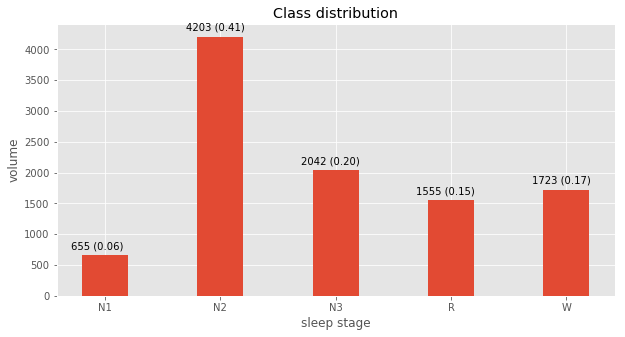

In [3]:
hx, hy = np.transpose(tuple(Counter(labels).items()))

# figure
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.set(title="Class distribution")
ax.bar(hx, hy, width=0.4)
ax.set_xticklabels([""] + [le.inverse_transform(x) for x in range(5)])
ax.set_xlabel("sleep stage")
ax.set_ylabel("volume")
total = np.sum(hy)
for i, j in zip(hx, hy):
    ax.text(i - 0.3, j + 100, "%d (%.2f)" % (j, j/total))
plt.show()

### Plot EEG signal

In [4]:
# sub-sampling if needed
subsampling = None
x_sub = x[:, ::subsampling]
print(x.shape)

(10178, 6000)


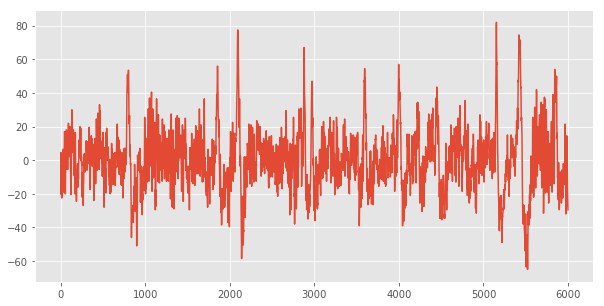

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(x_sub[0])

### Some hyper-parameters

In [6]:
# parameters
win_sec = 1
overlap = 0.2

# pretty print
n, sample_size = x_sub.shape
freq = sample_size / 30
num_classes = np.shape(y)[1]

# first pooling
win_size = int(win_sec * freq)
overlap_size = int(overlap * freq)
filter_size = win_size
stride = overlap_size
print("%d samples" % n)
print("nb of classes: %d" % num_classes)
print("sampling rate: %.1f Hz" % freq)
print("signal's length: %d samples" % sample_size)
print("window of %.2f seconds --> filter of %d samples" % (win_sec, win_size))
print("stride of %.2f seconds --> stride of %d samples" % (overlap, overlap_size))

10178 samples
nb of classes: 5
sampling rate: 200.0 Hz
signal's length: 6000 samples
window of 1.00 seconds --> filter of 200 samples
stride of 0.20 seconds --> stride of 40 samples


### CNN builder functions

In [7]:
# helper functions 
def apply_conv1d(x, filter_size, stride, out_size):
    height = x.get_shape().as_list()[1]
    filter_shape = [height, filter_size, 1, out_size]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
    conv = tf.nn.conv2d(x,
                        W, 
                        strides=[1, 1, stride, 1],
                        padding='VALID',
                        data_format='NHWC',
                        name='conv1d')
    return conv

def stack_channels(x):
    shape = x.get_shape().as_list()
    heigth = shape[-1] 
    width = shape[2]
    return tf.reshape(x, [-1, heigth, width, 1], name="stack")

def apply_max_pool1d(x, window=20, stride=1):
    height = x.get_shape().as_list()[1]
    pool = tf.nn.max_pool(x,
                          ksize=[1, height, window, 1],
                          strides=[1, 1, stride, 1], 
                          padding='VALID',
                          data_format='NHWC',
                          name='pool')
    return pool

def apply_flatten(x):
    shape = x.get_shape().as_list()
    out_size = 1
    for dim in shape[1:]:
        out_size *= dim
    return tf.reshape(x, [-1, out_size], name='flatten')

def apply_fully_connected(x, out_size):
    in_size = x.get_shape().as_list()[-1]
    W = tf.Variable(
        tf.truncated_normal(
            [in_size, out_size], stddev=0.1 ),
        name="weights"
    )
    b = tf.Variable(tf.constant(0.1, shape=[out_size]), name="biases")
    return tf.nn.xw_plus_b(x, W, b, name="fully_connected_layer")

### CNN architecture

In [8]:
%%time

# reset graph for batch normalization
tf.reset_default_graph()

# placeholders
x_input = tf.placeholder(tf.float32, shape=[None, sample_size], name='x_input')
y_input = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_input')
dropout = tf.placeholder(tf.float32, name="dropout_keep_prob")
training_mode = tf.placeholder(tf.bool, name="training_mode")

with tf.device("/cpu:0"):
    
    with tf.name_scope("expand"):
        x_expanded = tf.reshape(x_input, [-1, 1, sample_size, 1])
    
    with tf.name_scope("convolution1"):
        conv = apply_conv1d(x_expanded, 200, 20, 300)
        norm = tf.layers.batch_normalization(conv, training=training_mode)
        relu = tf.nn.relu(norm)
        h_pool = apply_max_pool1d(relu, window=20, stride=5)
        
    with tf.name_scope("stack"):
        h_stack = stack_channels(h_pool)
        
    with tf.name_scope("dropout1"):
        h_drop = tf.nn.dropout(h_stack, dropout)
        
    with tf.name_scope("convolution2"):
        conv2 = apply_conv1d(h_drop, 20, 1, 100)
        norm2 = tf.layers.batch_normalization(conv2, training=training_mode)
        relu2 = tf.nn.relu(norm2)
        h2_pool = apply_max_pool1d(relu2, window=5, stride=1)
        
    with tf.name_scope("flatten"): 
        h2_flat = apply_flatten(h2_pool)
        
    with tf.name_scope("dropout2"):
        h2_drop = tf.nn.dropout(h2_flat, dropout)

    with tf.name_scope("fully_connect"):
        preds = apply_fully_connected(h2_drop, num_classes)
        
    with tf.name_scope("loss"):
        losses = tf.nn.softmax_cross_entropy_with_logits(
            logits=preds,
            labels=y_input,
            name='losses'
        )
        loss = tf.reduce_mean(losses, name='loss')

    with tf.name_scope("optimization"):
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(
                epsilon=1e-8,
            )
            train_op = optimizer.minimize(loss) 
        
    with tf.name_scope("accuracy"):
        labels_pred = tf.argmax(preds, axis=1, name='prediction') 
        labels_true = tf.argmax(y_input, axis=1, name='ground_truth')
        correct_predictions = tf.equal(labels_pred, labels_true, name='correct_prediction')
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
        
    init = tf.global_variables_initializer()

CPU times: user 794 ms, sys: 10 ms, total: 804 ms
Wall time: 804 ms


#### Testing specific layer

In [9]:
%%time
n_try = 10
layer_to_test = accuracy
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub[:n_try], y_input: y[:n_try], dropout: 1, training_mode: False}
    __ = sess.run(layer_to_test, feed_dict=D)
    
print(np.shape(__))

()
CPU times: user 188 ms, sys: 35 ms, total: 223 ms
Wall time: 99.6 ms


#### Testing whole architecture with whole dataset

In [10]:
%%time
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: x_sub, y_input: y, dropout: 1, training_mode: True}
    acc, lb_pred, lb_true = sess.run([accuracy, labels_pred, labels_true], feed_dict=D)
    
print(acc)
print(Counter(lb_pred))
print(Counter(lb_true))

0.182845
Counter({4: 5212, 3: 4803, 0: 109, 2: 30, 1: 24})
Counter({1: 4203, 2: 2042, 4: 1723, 3: 1555, 0: 655})
CPU times: user 6min 4s, sys: 1min 8s, total: 7min 12s
Wall time: 29.8 s


### Training CNN

#### Emptying tensorflow_summaries

In [11]:
path = "./tensorflow_summaries"
for file in os.listdir(path):
    filepath = os.path.join(path, file)
    if os.path.isfile(filepath) and file != ".gitkeep":
        os.remove(filepath)

#### Train helper functions

In [12]:
# accuracy and loss computation
def get_stat(sess, x, y, 
             x_input=x_input, y_input=y_input, dropout=dropout, training_mode=training_mode):
    feed_dict={x_input: x, y_input: y, dropout: 1, training_mode: False}
    acc, l = sess.run([accuracy, loss], feed_dict=feed_dict)
    return acc, l

def print_acc_loss(acc_train, loss_train, acc_test, loss_test, epoch=-1):
    if  epoch == -1:
        log_string = "init. __    train acc: %0.2f  test acc: %0.2f" % (acc_train, acc_test)
    else:
        log_string = "epoch %2d    train acc: %0.2f  test acc: %0.2f" % (epoch, acc_train, acc_test)
    log_string += " " * 3
    log_string += "loss train: %7.2f  loss test: %7.2f" % (loss_train, loss_test)
    print(log_string)

#### Training loop

In [13]:
batch_size = 64
num_epochs = 25
p = 0.5
seed = 42
splits = train_test_split(x_sub, y, labels, train_size=0.75, random_state=seed)
x_train, x_test, y_train, y_test, labels_train, labels_test = splits

In [14]:
%%time
np.random.seed(10)
with tf.Session() as sess:
    # init
    sess.run(init)
    train_stat = get_stat(sess, x_train, y_train)
    test_stat = get_stat(sess, x_test, y_test)
    print_acc_loss(*train_stat, *test_stat)
    
    # training
    losses = []
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            batch_xs = x_train[idx: idxn]
            batch_ys = y_train[idx: idxn]
            feed_train = {x_input: batch_xs, y_input: batch_ys, dropout: p, training_mode: True}
            __, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)
            
        train_stat = get_stat(sess, x_train, y_train)
        test_stat = get_stat(sess, x_test, y_test)
        print_acc_loss(*train_stat, *test_stat, epoch=e)
        
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)
    
    # use trained model
    feed = {x_input: x_test, y_input: y_test, dropout: 1, training_mode: False}
    lb_pred, lb_true = sess.run([labels_pred, labels_true], feed_dict=feed)
    
# close file writer
file_writer.close()

init. __    train acc: 0.16  test acc: 0.16   loss train: 1788.87  loss test: 1770.29
epoch  0    train acc: 0.24  test acc: 0.24   loss train:    6.31  loss test:    6.61
epoch  1    train acc: 0.51  test acc: 0.51   loss train:    1.85  loss test:    1.98
epoch  2    train acc: 0.66  test acc: 0.67   loss train:    1.13  loss test:    1.22
epoch  3    train acc: 0.66  test acc: 0.66   loss train:    1.05  loss test:    1.15
epoch  4    train acc: 0.69  test acc: 0.69   loss train:    0.90  loss test:    1.00
epoch  5    train acc: 0.71  test acc: 0.71   loss train:    0.84  loss test:    0.91
epoch  6    train acc: 0.72  test acc: 0.73   loss train:    0.79  loss test:    0.86
epoch  7    train acc: 0.71  test acc: 0.72   loss train:    0.81  loss test:    0.89
epoch  8    train acc: 0.74  test acc: 0.74   loss train:    0.71  loss test:    0.77
epoch  9    train acc: 0.76  test acc: 0.76   loss train:    0.66  loss test:    0.73
epoch 10    train acc: 0.75  test acc: 0.75   loss tra

#### Training loss 

Counter({1: 1089, 2: 599, 4: 426, 3: 415, 0: 16})
Counter({1: 1081, 2: 505, 4: 438, 3: 377, 0: 144})


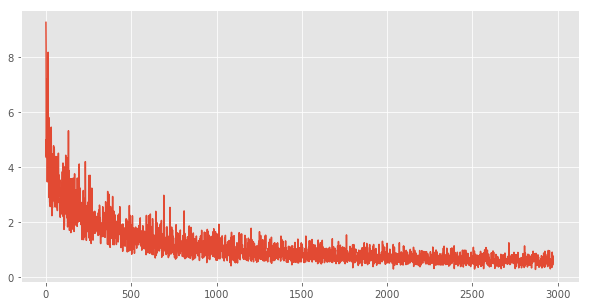

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(losses)
print(Counter(lb_pred))
print(Counter(lb_true))

### Confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [17]:
cf_mat = confusion_matrix(lb_true, lb_pred)
cf_df = pd.DataFrame(cf_mat)
cf_df.index.name = "truth"
cf_df.columns.name = "predicted"
print(cf_df.to_string())

predicted  0    1    2    3    4
truth                           
0          5   50    4   67   18
1          4  895  130   44    8
2          0   49  456    0    0
3          0   75    1  286   15
4          7   20    8   18  385
